In [1]:
import pymc as pm
import seaborn as sns
import bambi as bmb
import pandas as pd
import matplotlib.pyplot as plt
import preliz as pz
import arviz as az
import os
import numpy as np
import pytensor  
import gzip
import pickle
import cloudpickle
import gdown
import tempfile

In [2]:
file_id = "1P2-DrRmHUoO7d8lmZ480xrmbrGuxpCoI"
url = f"https://drive.google.com/uc?id={file_id}"

try:
    with tempfile.NamedTemporaryFile(suffix=".csv", delete=False) as tmp:
        tmp_path = tmp.name

    gdown.download(url, tmp_path, quiet=False)

    df = pd.read_pickle(tmp_path)
except Exception as e:
    print("No data on g-drive")

Downloading...
From: https://drive.google.com/uc?id=1P2-DrRmHUoO7d8lmZ480xrmbrGuxpCoI
To: C:\Users\kugor\AppData\Local\Temp\tmppb1fx13q.csv
100%|██████████| 24.4M/24.4M [00:01<00:00, 17.4MB/s]


In [3]:
df["stress"] = df["label"].replace({
    "Brak stresu": 0,
    "Niski/Średni": 1,
    "Wysoki": 2
})

cat_nurse = pd.Categorical(df['id'])
df["nurse_idx"] = cat_nurse.codes
n_nurses = len(cat_nurse.categories)
coords = {"nurse": cat_nurse.categories,
          "stress": ["Niski/Średni", "Wysoki"]}
stress = df["stress"].values
nurse_idx = df["nurse_idx"].values
temp = df["TEMP"].values
df=pd.concat([pd.get_dummies(df, columns=["label"], dtype="int32", drop_first=True), df['label']], axis=1)

C:\Users\kugor\AppData\Local\Temp\ipykernel_18532\3800859301.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["stress"] = df["label"].replace({


In [4]:
comparisons = {}

for var in ["TEMP", "HR"]:
    comparisons[var] = pd.read_pickle(f"../data/processed/{var}_model_comparison.pkl")
    comparisons[var] = comparisons[var].iloc[:, 0:2].round(2)
    comparisons[var].iloc[:,0] = comparisons[var].iloc[:,0] +1
    comparisons[var].to_excel(f"../data/processed/{var}_model_comparison_excel.xlsx")    

In [5]:
comparisons["TEMP"] = comparisons["TEMP"].iloc[:, 0:2].round(2)
comparisons["TEMP"].iloc[:,0] = comparisons["TEMP"].iloc[:,0] +1

In [6]:
comparisons["TEMP"]


,rank,elpd_loo
no_pool_sigma_dep,2,-51404.42
no_pool_oh,3,-53304.68
partial_pool,4,-53682.22
no_pool_ord,5,-53682.48


In [6]:
# === Partial Pooling - Heteroskedastic (Sigma ~ Stress, Varying by Nurse), one hot encoding, NON-CENTERED PARAMETRIZATION===
models = {}
idata = {}

for var in ["TEMP", "HR"]:
    print(f"---------------------{var} model---------------------")
    outcome = df[var].values   
    with pm.Model(coords=coords) as m_hier_sigma_dep_oh_reparam:
        # Hyperpriors for the common slopes
        mu_alpha = pm.Normal("mu_alpha", mu=df[var].mean(), sigma=0.5)
        sigma_alpha = pm.Exponential("sigma_alpha", 1.0)
        mu_beta_0 = pm.Normal("mu_beta_0", mu=0, sigma=1)  # Common slope for beta_0
        mu_beta_1 = pm.Normal("mu_beta_1", mu=0, sigma=1)  # Common slope for beta_1
        sigma_beta_0 = pm.Exponential("sigma_beta_0", 1.0)    
        sigma_beta_1 = pm.Exponential("sigma_beta_1", 1.0)
        
        # Group-level intercept
        alpha = pm.Normal("alpha", mu=mu_alpha, sigma=sigma_alpha, dims="nurse")
        
        # Varying slopes are now deviations from the common slopes (mu_beta_0 and mu_beta_1)
        beta_offset_0 = pm.Normal("beta_offset_0", mu=0, sigma=sigma_beta_0, dims="nurse")  # Deviation from mu_beta_0
        beta_offset_1 = pm.Normal("beta_offset_1", mu=0, sigma=sigma_beta_1, dims="nurse")  # Deviation from mu_beta_1
        
        # Varying slopes for each nurse are now defined as the common slope plus the deviation
        beta_0 = pm.Deterministic("beta_0", mu_beta_0 + beta_offset_0)
        beta_1 = pm.Deterministic("beta_1", mu_beta_1 + beta_offset_1)
        
        # Priors for the baseline log(sigma)
        mu_sigma_intercept = pm.Normal("mu_sigma_intercept", mu=0, sigma=1)

        # Priors for the effect of 'Niski/Średni' stress on log(sigma)
        mu_sigma_beta_0 = pm.Normal("mu_sigma_beta_0", mu=0, sigma=1)

        # Priors for the effect of 'Wysoki' stress on log(sigma)
        mu_sigma_beta_1 = pm.Normal("mu_sigma_beta_1", mu=0, sigma=1)

        # Model for log(sigma) depending on stress level (non-hierarchical)
        log_sigma = (
            mu_sigma_intercept
            + mu_sigma_beta_0 * df["label_Niski/Średni"].values
            + mu_sigma_beta_1 * df["label_Wysoki"].values
        )
        sigma = pm.Deterministic("sigma", pm.math.exp(log_sigma))
        
        # Model equation with varying intercepts and slopes
        mu = alpha[nurse_idx] + beta_0[nurse_idx] * df["label_Niski/Średni"].values + beta_1[nurse_idx] * df["label_Wysoki"].values

        if var == "TEMP":
            pm.Normal("y_obs", mu=mu, sigma=sigma, observed=outcome)
        if var == "EDA":
            alpha_skew = pm.Normal("alpha_skew", mu=0, sigma=5)
            pm.SkewNormal("y_obs", mu=mu, alpha=alpha_skew, sigma=sigma, observed=outcome)
        if var == "HR":
            nu = pm.Exponential("nu", 1)
            pm.StudentT("y_obs", mu=mu, nu=nu, sigma=sigma, observed=outcome)

        # Sampling with the reparameterized model
        # idata_hier_sigma_dep_nurse_reparam = pm.sample(2000, tune=2000, chains=4,
        #                                               cores=4, random_state=42, target_accept=0.9)
    
    models[var] = m_hier_sigma_dep_oh_reparam
    # idata[var] = idata_hier_sigma_dep_nurse_reparam

    # # az.plot_trace(idata_hier_sigma_dep_nurse, var_names = ["mu_alpha", "mu_beta_0", "mu_beta_1", "alpha", "beta_0", "beta_1"]); plt.tight_layout()
    # # plt.savefig(f"../reports/figures/trace_plots/{var}_m5_partial_pool_oh_sigma_dep_trace.png", bbox_inches="tight")       

    # # Prepare objects to save with cloudpickle
    # dict_to_save = {
    #     'model': m_hier_sigma_dep_oh_reparam,
    #     'idata': idata_hier_sigma_dep_nurse_reparam
    # }

    # # Save the dictionary using cloudpickle
    # pickle_filepath = os.path.join(models_dir, f"{var}_model_idata.pkl")
    # with open(pickle_filepath, 'wb') as buff:
    #     cloudpickle.dump(dict_to_save, buff)

    # print(f"Saved model and idata for {var} to {pickle_filepath}")

---------------------TEMP model---------------------
---------------------HR model---------------------


In [8]:
models_dir = "../models/"
vars = ["TEMP", "HR"]
idatas={}

for var in vars:
    idata_path = os.path.join(models_dir, f"{var}_idata.nc")
    model_path = os.path.join(models_dir, f"{var}_model.pkl")

    # Load idata 
    idata = az.from_netcdf(idata_path)
    idatas[var] = idata

In [9]:
# models

In [10]:
idatas

{'TEMP': Inference data with groups:
 	> posterior
 	> sample_stats
 	> observed_data,
 'HR': Inference data with groups:
 	> posterior
 	> sample_stats
 	> observed_data}

In [9]:
for group in ["TEMP", "HR"]:
    posterior = idatas[group].posterior
    nurse_labels = cat_nurse.categories

    for var in ["beta_0", "beta_1"]:
        arr = posterior[var]
        old_dim = arr.dims[-1]
        idatas[group].posterior[var] = arr.rename({old_dim: "nurse"}).assign_coords(nurse=("nurse", nurse_labels))

In [10]:
rename_dict = {
    'mu_alpha': 'μₐ',
    'sigma_alpha': 'σₐ',
    'mu_beta_0': 'μᵦ₀',
    'mu_beta_1': 'μᵦ₁',
    'sigma_beta_0': 'σᵦ₀',
    'sigma_beta_1': 'σᵦ₁',
    'alpha': 'α',
    'beta_0': 'β₀',
    'beta_1': 'β₁',
    'sigma': 'σ',
    'nu': 'ν',  
    'mu_sigma_intercept': 'α_σ',
    'mu_sigma_beta_0': 'β₀_σ',
    'mu_sigma_beta_1': 'β₁_σ',
}

idatas["TEMP"].rename_vars(rename_dict, inplace=True)
idatas["HR"].rename_vars(rename_dict, inplace=True)

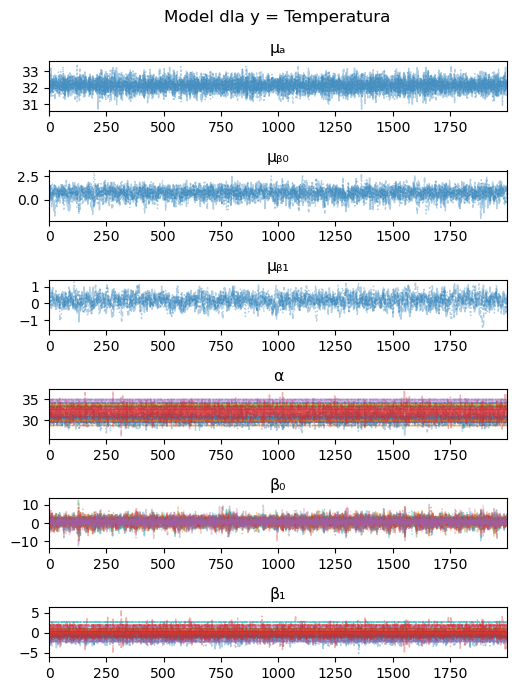

In [13]:
axes = az.plot_trace(
    idatas["TEMP"],
    var_names=["μₐ", "μᵦ₀", "μᵦ₁", "α", "β₀", "β₁"],
    figsize=(10, 7))

for row in axes:
    row[0].set_visible(False)  #
plt.suptitle("Model dla y = Temperatura", x=0.755)
plt.tight_layout()
plt.savefig(f"../reports/figures/10-trace-plot-temp.png", bbox_inches="tight")

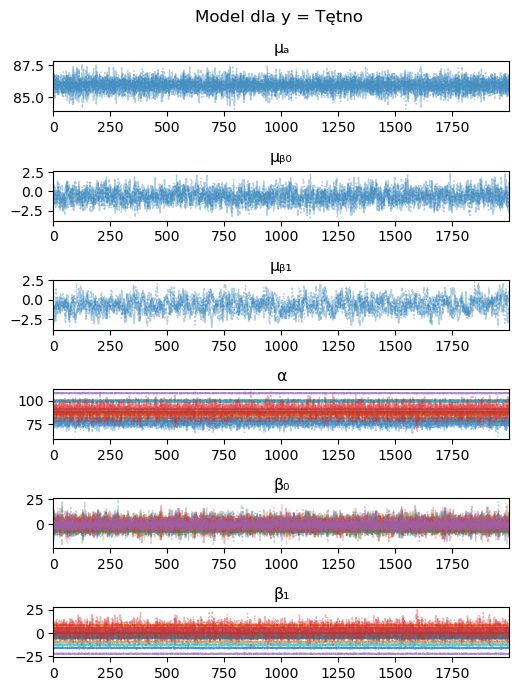

In [11]:
axes = az.plot_trace(
    idatas["HR"],
    var_names=["μₐ", "μᵦ₀", "μᵦ₁", "α", "β₀", "β₁"],
    figsize=(10, 7))

for row in axes:
    row[0].set_visible(False)  #
plt.suptitle("Model dla y = Tętno", x=0.755)
plt.tight_layout()
plt.savefig(f"../reports/figures/11-trace-plot-tętno.png", bbox_inches="tight")

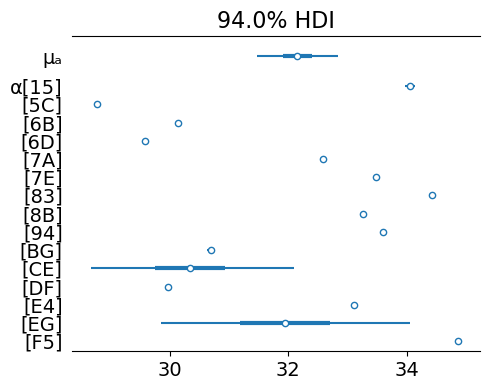

In [33]:
az.plot_forest(idatas["TEMP"], var_names=["μₐ", "α"], combined=True, figsize=(5,4), ); plt.tight_layout()

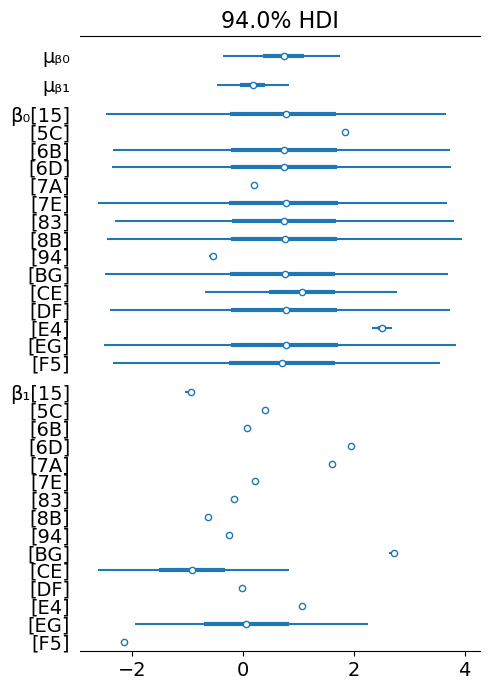

In [16]:
az.plot_forest(idatas["TEMP"], var_names=["μᵦ₀", "μᵦ₁", "β₀", "β₁"], combined=True, figsize=(5,7), ); plt.tight_layout()

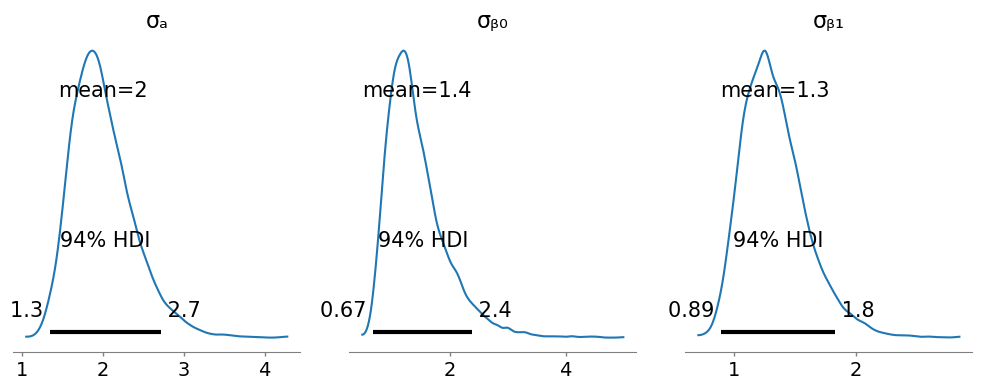

In [17]:
az.plot_posterior(idatas["TEMP"], var_names=["σₐ", "σᵦ₀", "σᵦ₁"], figsize=(10, 4)); plt.tight_layout()

In [18]:
def plot_posterior_grid(idatas, var_names, figsize=(10, 5), titles=("Model dla y = Temperatura", "Model dla y = Tętno")):
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    for i, key in enumerate(["TEMP", "HR"]):
        idata = idatas[key]
        ax = axes[i]

        if any("σ" in var for var in var_names):
            az.plot_posterior(
                idata,
                var_names=var_names,
                ax=ax
            )
        else:
            az.plot_forest(
                idata,
                var_names=var_names,
                combined=True,
                ax=ax
            )
            ax.set_title(titles[i])

    plt.tight_layout()

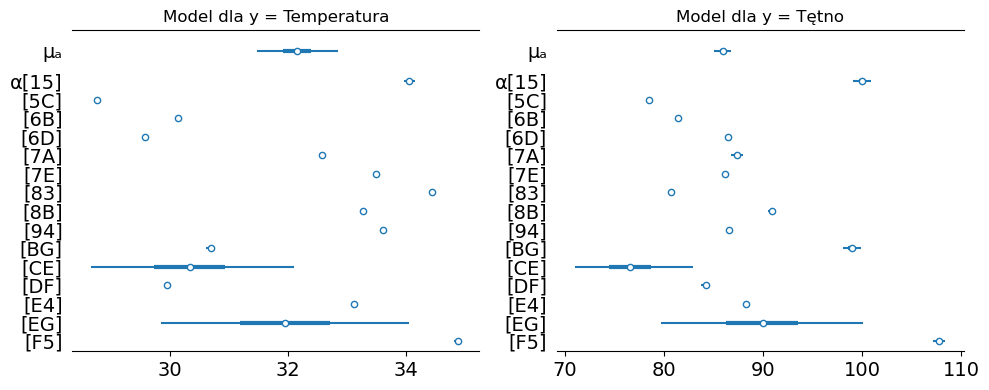

In [19]:
plot_posterior_grid(idatas, var_names=["μₐ", "α"],figsize=(10, 4))
plt.savefig(f"../reports/figures/12-forest-plot-alpha.png", bbox_inches="tight")

In [20]:
temp_summary = az.summary(idatas["TEMP"], var_names=["μₐ", "α"], round_to=2, kind='stats', hdi_prob=0.94).add_prefix("TEMP_")
hr_summary = az.summary(idatas["HR"], var_names=["μₐ", "α"], round_to=2, kind='stats').add_prefix("HR_")

pd.concat([temp_summary, hr_summary], axis=1)

,TEMP_mean,TEMP_sd,TEMP_hdi_3%,TEMP_hdi_97%,HR_mean,HR_sd,HR_hdi_3%,HR_hdi_97%
μₐ,32.16,0.36,31.48,32.84,85.93,0.48,85.02,86.81
α[15],34.05,0.05,33.96,34.14,99.98,0.48,99.12,100.94
α[5C],28.77,0.01,28.75,28.79,78.52,0.12,78.30,78.74
α[6B],30.14,0.02,30.11,30.17,81.42,0.19,81.07,81.79
α[6D],29.59,0.01,29.58,29.60,86.50,0.09,86.31,86.67
α[7A],32.58,0.03,32.53,32.63,87.35,0.32,86.76,87.94
α[7E],33.48,0.02,33.45,33.52,86.19,0.18,85.84,86.52
α[83],34.43,0.01,34.40,34.45,80.66,0.15,80.37,80.93
α[8B],33.27,0.01,33.24,33.30,90.89,0.18,90.54,91.20
α[94],33.60,0.01,33.58,33.62,86.54,0.11,86.33,86.74


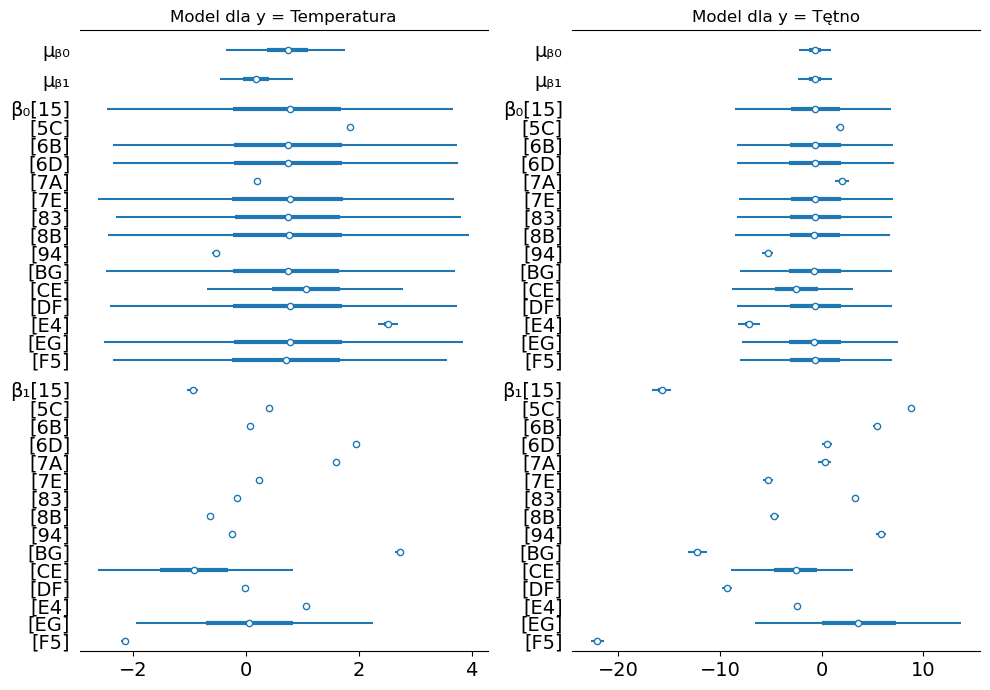

In [21]:
plot_posterior_grid(idatas, var_names=["μᵦ₀", "μᵦ₁", "β₀", "β₁"],figsize=(10, 7))
plt.savefig(f"../reports/figures/13-forest-plot-beta.png", bbox_inches="tight")

In [22]:
temp_summary = az.summary(idatas["TEMP"], var_names=["μᵦ₀", "μᵦ₁", "β₀", "β₁"], round_to=2, kind='stats', hdi_prob=0.94).add_prefix("TEMP_")
hr_summary = az.summary(idatas["HR"], var_names=["μᵦ₀", "μᵦ₁", "β₀", "β₁"], round_to=2, kind='stats').add_prefix("HR_")

summary_beta = pd.concat([temp_summary, hr_summary], axis=1)
summary_beta

,TEMP_mean,TEMP_sd,TEMP_hdi_3%,TEMP_hdi_97%,HR_mean,HR_sd,HR_hdi_3%,HR_hdi_97%
μᵦ₀,0.71,0.57,-0.36,1.75,-0.63,0.86,-2.29,0.90
μᵦ₁,0.17,0.35,-0.46,0.83,-0.66,0.90,-2.36,1.03
β₀[15],0.69,1.61,-2.46,3.66,-0.58,4.00,-8.56,6.78
β₀[5C],1.84,0.02,1.79,1.88,1.76,0.19,1.41,2.11
β₀[6B],0.73,1.62,-2.34,3.72,-0.62,4.06,-8.29,7.05
β₀[6D],0.72,1.61,-2.36,3.75,-0.59,4.05,-8.37,7.12
β₀[7A],0.20,0.03,0.14,0.26,1.95,0.34,1.34,2.64
β₀[7E],0.72,1.66,-2.61,3.67,-0.60,3.96,-8.14,7.04
β₀[83],0.71,1.63,-2.30,3.80,-0.61,4.02,-8.36,6.91
β₀[8B],0.70,1.66,-2.44,3.94,-0.69,4.03,-8.50,6.73


In [23]:
summary_beta_individual = summary_beta.iloc[2:, :]
summary_beta_individual['effect_TEMP'] = np.where(summary_beta_individual["TEMP_hdi_3%"]>0, "Positive",
                                             np.where(summary_beta_individual["TEMP_hdi_97%"]<0, "Negative", "No effect"))

C:\Users\kugor\AppData\Local\Temp\ipykernel_952\619508179.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_beta_individual['effect_TEMP'] = np.where(summary_beta_individual["TEMP_hdi_3%"]>0, "Positive",


In [24]:
summary_beta_individual['effect_HR'] = np.where(summary_beta_individual["HR_hdi_3%"]>0, "Positive",
                                             np.where(summary_beta_individual["HR_hdi_97%"]<0, "Negative", "No effect"))

C:\Users\kugor\AppData\Local\Temp\ipykernel_952\857181695.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_beta_individual['effect_HR'] = np.where(summary_beta_individual["HR_hdi_3%"]>0, "Positive",


In [25]:
summary_beta_individual

,TEMP_mean,TEMP_sd,TEMP_hdi_3%,TEMP_hdi_97%,HR_mean,HR_sd,HR_hdi_3%,HR_hdi_97%,effect_TEMP,effect_HR
β₀[15],0.69,1.61,-2.46,3.66,-0.58,4.00,-8.56,6.78,No effect,No effect
β₀[5C],1.84,0.02,1.79,1.88,1.76,0.19,1.41,2.11,Positive,Positive
β₀[6B],0.73,1.62,-2.34,3.72,-0.62,4.06,-8.29,7.05,No effect,No effect
β₀[6D],0.72,1.61,-2.36,3.75,-0.59,4.05,-8.37,7.12,No effect,No effect
β₀[7A],0.20,0.03,0.14,0.26,1.95,0.34,1.34,2.64,Positive,Positive
β₀[7E],0.72,1.66,-2.61,3.67,-0.60,3.96,-8.14,7.04,No effect,No effect
β₀[83],0.71,1.63,-2.30,3.80,-0.61,4.02,-8.36,6.91,No effect,No effect
β₀[8B],0.70,1.66,-2.44,3.94,-0.69,4.03,-8.50,6.73,No effect,No effect
β₀[94],-0.54,0.04,-0.61,-0.46,-5.32,0.28,-5.86,-4.81,Negative,Negative
β₀[BG],0.70,1.60,-2.48,3.68,-0.67,3.95,-8.07,6.89,No effect,No effect


In [26]:
df['id'].unique().shape[0]

15

In [27]:
summary_beta_individual.loc[summary_beta_individual.index.str.contains("β₀"), 'effect_TEMP'].value_counts()

effect_TEMP
No effect    11
Positive      3
Negative      1
Name: count, dtype: int64

In [28]:
summary_beta_individual.loc[summary_beta_individual.index.str.contains("β₁"), 'effect_TEMP'].value_counts()

effect_TEMP
Positive     7
Negative     5
No effect    3
Name: count, dtype: int64

In [29]:
summary_beta_individual.loc[summary_beta_individual.index.str.contains("β₀"), 'effect_HR'].value_counts()

effect_HR
No effect    11
Positive      2
Negative      2
Name: count, dtype: int64

In [30]:
summary_beta_individual.loc[summary_beta_individual.index.str.contains("β₁"), 'effect_HR'].value_counts()

effect_HR
Negative     7
Positive     5
No effect    3
Name: count, dtype: int64

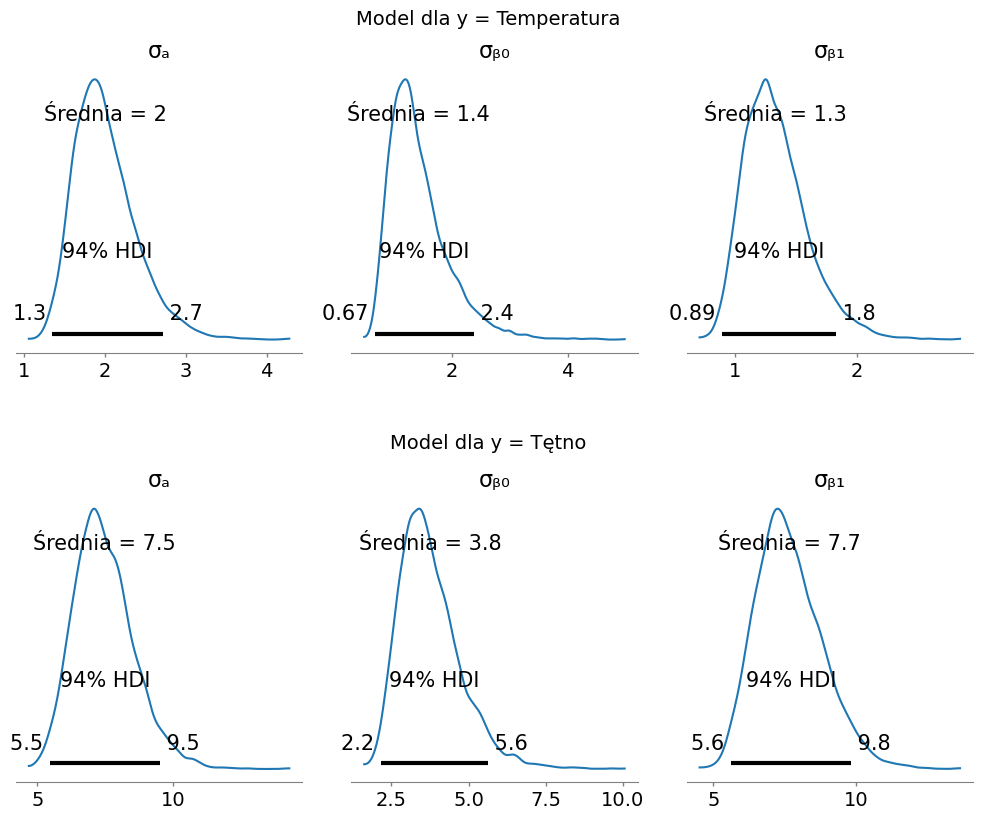

In [23]:
fig, ax = plt.subplots(2, 3, figsize=(10, 8))
ax = ax.flatten()

az.plot_posterior(idatas["TEMP"], var_names=["σₐ", "σᵦ₀", "σᵦ₁"], ax=ax[0:3])
az.plot_posterior(idatas["HR"], var_names=["σₐ", "σᵦ₀", "σᵦ₁"], ax=ax[3:6])

# Replace "mean:" with "Średnia:"
for axes in ax:
    for text in axes.texts:
        txt = text.get_text()
        if txt.startswith("mean") and "=" in txt:
            val = txt.split("=", 1)[1].strip()
            text.set_text(f"Średnia = {val}")
# Add row titles
fig.text(0.5, 1, "Model dla y = Temperatura", ha='center', fontsize=14)
fig.text(0.5, 0.47, "Model dla y = Tętno", ha='center', fontsize=14)

plt.tight_layout()  # leave space at top for titles
plt.subplots_adjust(hspace=0.5)  
plt.savefig(f"../reports/figures/14-posterior-sigma.png", bbox_inches="tight")
plt.show()

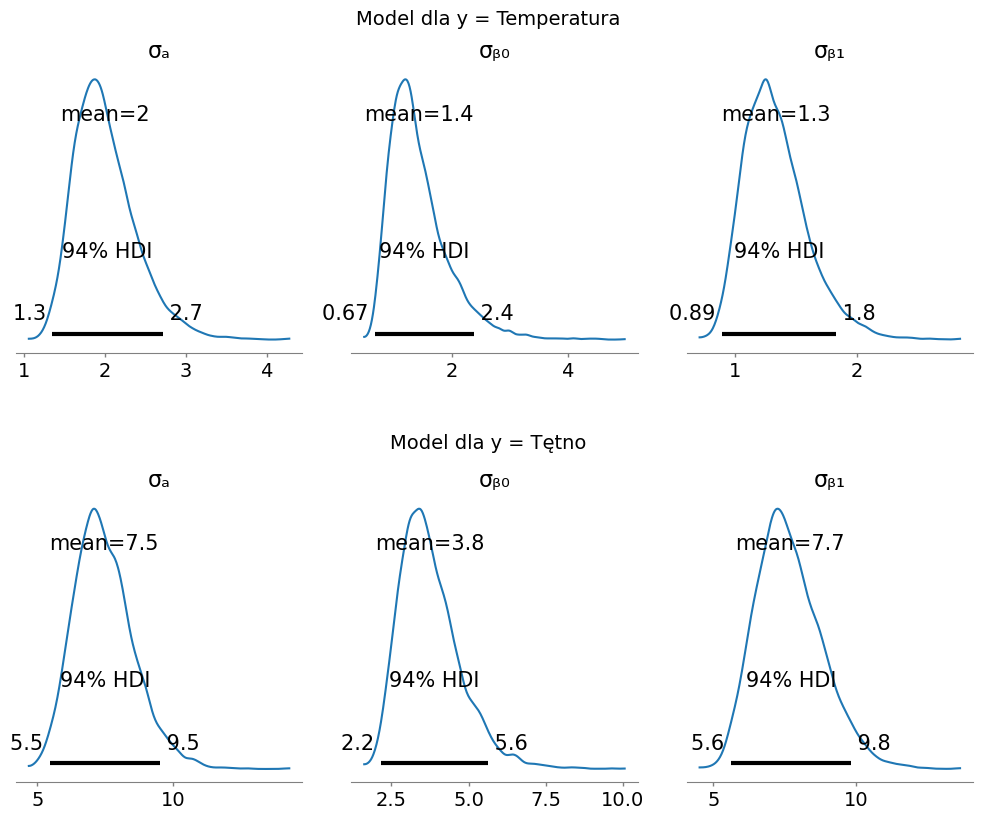

In [13]:
fig, ax = plt.subplots(2, 3, figsize=(10, 8))
ax = ax.flatten()

az.plot_posterior(idatas["TEMP"], var_names=["σₐ", "σᵦ₀", "σᵦ₁"], ax=ax[0:3], )
az.plot_posterior(idatas["HR"], var_names=["σₐ", "σᵦ₀", "σᵦ₁"], ax=ax[3:6])

# Add titles above each row
fig.text(0.5, 1, "Model dla y = Temperatura", ha='center', fontsize=14)
fig.text(0.5, 0.47, "Model dla y = Tętno", ha='center', fontsize=14)

plt.tight_layout()  # leave space at top for titles
plt.subplots_adjust(hspace=0.5)  
plt.savefig(f"../reports/figures/14-posterior-sigma.png", bbox_inches="tight")
plt.show()

In [25]:
temp_summary_sigma = az.summary(idatas["TEMP"], var_names=["σₐ", "σᵦ₀", "σᵦ₁"], round_to=2, kind='stats', hdi_prob=0.94).add_prefix("TEMP_")
hr_summary_sigma = az.summary(idatas["HR"], var_names=["σₐ", "σᵦ₀", "σᵦ₁"], round_to=2, kind='stats').add_prefix("HR_")

pd.concat([temp_summary_sigma, hr_summary_sigma], axis=1)

,TEMP_mean,TEMP_sd,TEMP_hdi_3%,TEMP_hdi_97%,HR_mean,HR_sd,HR_hdi_3%,HR_hdi_97%
σₐ,2.00,0.38,1.35,2.71,7.47,1.11,5.46,9.51
σᵦ₀,1.42,0.52,0.67,2.38,3.75,1.00,2.15,5.63
σᵦ₁,1.33,0.26,0.89,1.83,7.66,1.16,5.61,9.83
